In [ ]:
import csv
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from xgboost import plot_tree
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

## Première approche
On utilise CSV reader afin de pouvoir lire les touches utilisées et les ranger dans un dictionnaire
On calcule les fréquences pour chaque hotkey

In [ ]:
"""
rows_list = []
train_data = pd.DataFrame()

with open('../input/starcraft-2-player-prediction-challenge-2020/TRAIN.CSV', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        #row = row[:150]
        row = list(filter(lambda term : not term.startswith('t'), row))
        
        dictionary={
                'id' : row[0],
                'Race': row[1], 
                'Base': 0,
                'SingleMineral': 0,
                's': 0,
                'hotkey00': 0,
                'hotkey01': 0,
                'hotkey02': 0,
                'hotkey10': 0,
                'hotkey11': 0,
                'hotkey12': 0,
                'hotkey20': 0,
                'hotkey21': 0,
                'hotkey22': 0,
                'hotkey30': 0,
                'hotkey31': 0,
                'hotkey32': 0,
                'hotkey40': 0,
                'hotkey41': 0,
                'hotkey42': 0,
                'hotkey50': 0,
                'hotkey51': 0,
                'hotkey52': 0,
                'hotkey60': 0,
                'hotkey61': 0,
                'hotkey62': 0,
                'hotkey70': 0,
                'hotkey71': 0,
                'hotkey72': 0,
                'hotkey80': 0,
                'hotkey81': 0,
                'hotkey82': 0,
                'hotkey90': 0,
                'hotkey91': 0,
                'hotkey92': 0,
            }
        
        race = dictionary['Race']
        if race == 'Zerg':
            dictionary['Race'] = 0
        elif race == 'Terran':
            dictionary['Race'] = 1
        else:
            dictionary['Race'] = 2
                    
        row.pop(0)   
        row.pop(0)        

        actionsTotales = 0
        for action in row:
            actionsTotales = actionsTotales + 1
            value = dictionary.get(action)
            
            if value is None:
                print('This action should exist')
            else:
                dictionary[action] = value + 1
            
        for item in dictionary:
            if item != 'Race' and item != 'id':
                    if dictionary[item] != 0:
                        dictionary[item]=dictionary[item]/actionsTotales
                    else:
                        dictionary[item]=0.
             
        rows_list.append(dictionary)

train_data = train_data.append(rows_list)
"""

In [ ]:
"""
rows_list_test = []
test_data = pd.DataFrame()

with open('../input/starcraft-2-player-prediction-challenge-2020/TEST.CSV', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        #row = row[:150]
        row = list(filter(lambda term : not term.startswith('t'), row))
        dictionary={
                'Race': row[0], 
                'Base': 0,
                'SingleMineral': 0,
                's': 0,
                'hotkey00': 0,
                'hotkey01': 0,
                'hotkey02': 0,
                'hotkey10': 0,
                'hotkey11': 0,
                'hotkey12': 0,
                'hotkey20': 0,
                'hotkey21': 0,
                'hotkey22': 0,
                'hotkey30': 0,
                'hotkey31': 0,
                'hotkey32': 0,
                'hotkey40': 0,
                'hotkey41': 0,
                'hotkey42': 0,
                'hotkey50': 0,
                'hotkey51': 0,
                'hotkey52': 0,
                'hotkey60': 0,
                'hotkey61': 0,
                'hotkey62': 0,
                'hotkey70': 0,
                'hotkey71': 0,
                'hotkey72': 0,
                'hotkey80': 0,
                'hotkey81': 0,
                'hotkey82': 0,
                'hotkey90': 0,
                'hotkey91': 0,
                'hotkey92': 0,
            }
        
        race = dictionary['Race']
        if race == 'Zerg':
            dictionary['Race'] = 0
        elif race == 'Terran':
            dictionary['Race'] = 1
        else:
            dictionary['Race'] = 2
                    
        row.pop(0)        

        actionsTotales = 0
        for action in row:
            actionsTotales = actionsTotales + 1
            value = dictionary.get(action)
            
            if value is None:
                print('This action should exist')
            else:
                dictionary[action] = value + 1
            
        for item in dictionary:
            if item != 'Race' and item != 'id':
                    if dictionary[item] != 0:
                        dictionary[item]=dictionary[item]/actionsTotales
                    else:
                        dictionary[item]=0.
             
        rows_list_test.append(dictionary)

test_data = test_data.append(rows_list_test)
"""

## Deuxième approche
On va tout d'abord importer toutes les actions dans un dataframe. Nous allons séparer les races et les minéraux des auttres hotkey.

In [ ]:
def read_train(f):
    data = []
    with open(f, 'r') as file:
        for row in file:
            row_data = row.replace('\n','').split(',')
            profile_id, race, actions = row_data[0],row_data[1],row_data[2:]
            data.append([profile_id,race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['id', 'race','actions'])
    return df
    
def read_test(f):
    data = []
    with open(f, 'r') as file:
        for row in file:
            row_data = row.replace('\n','').split(',')
            race, actions = row_data[0],row_data[1:]
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    return df

In [ ]:
train_data = read_train('../input/starcraft-2-player-prediction-challenge-2020/TRAIN.CSV')
test_data = read_test('../input/starcraft-2-player-prediction-challenge-2020/TEST.CSV')

In [ ]:
train_data.head()

In [ ]:
test_data.head()

### Analyse des données brutes

Analyse de la répartition par terrain

In [ ]:
races = train_data['race'].value_counts()
plot = races.plot.bar()

Observation des profils sur lesquels nous disposons de beaucoup de données

In [ ]:
train_data['id'].value_counts()

Puis création d'une nouvelle fonction pour pouvoir prendre en compte les temps utilisés sur chaque hotkey

In [ ]:
hotkeys = ['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']


def build_features(dataframe):
    feature_set = []
    ids = []
    for index, row in dataframe.iterrows():
        ids.append(row[0])
        hotkey_counter = {hotkey:0 for hotkey in hotkeys}
        hotkey_counter_t0 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t5 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t15 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t30 = {hotkey:0 for hotkey in hotkeys}
        hotkey_counter_t60 = {hotkey:0 for hotkey in hotkeys}
        actions = row["actions"]
        cpt = 1
        cpt_t0 = 1
        cpt_t5 = 1
        cpt_t15 = 1
        cpt_t30 = 1
        cpt_t60 = 1
        time = 0
        for action in actions.split(','):
            action = action.strip()
            if action in hotkeys:
                hotkey_counter[action]+=1
                cpt+=1
            if 't5' in action :
                time = 5
            if 't15' in action :
                time = 15
            if 't30' in action :
                time = 30
            if 't60' in action :
                time = 60
            if 't90' in action :
                break
            if action in hotkeys and time == 0 :
                hotkey_counter_t0[action]+=1
                cpt_t0+=1
            if action in hotkeys and time == 5 :
                hotkey_counter_t5[action]+=1
                cpt_t5+=1
            if action in hotkeys and time == 15 :
                hotkey_counter_t15[action]+=1
                cpt_t15+=1
            if action in hotkeys and time == 30 :
                hotkey_counter_t30[action]+=1
                cpt_t30+=1
            if action in hotkeys and time == 60 :
                hotkey_counter_t60[action]+=1
                cpt_t60+=1
        data = [row['race'], *[hotkey_counter[action]/cpt for action in hotkeys], *[hotkey_counter_t0[action]/cpt_t0 for action in hotkeys], *[hotkey_counter_t5[action]/cpt_t5 for action in hotkeys], *[hotkey_counter_t15[action]/cpt_t15 for action in hotkeys], *[hotkey_counter_t30[action]/cpt_t30 for action in hotkeys], *[hotkey_counter_t60[action]/cpt_t60 for action in hotkeys]]
        feature_set.append(data)
    feature_df = pd.DataFrame(feature_set, columns=['race', *hotkeys, *[hotkeys+'_t0' for hotkeys in hotkeys], *[hotkeys+'_t5' for hotkeys in hotkeys], *[hotkeys+'_t15' for hotkeys in hotkeys], *[hotkeys+'_t30' for hotkeys in hotkeys], *[hotkeys+'_t60' for hotkeys in hotkeys]])
    return feature_df

In [ ]:
feature_df = build_features(train_data)

In [ ]:
feature_df

Nous allons à présent sélectionner les id pour pouvoir entraîner nos arbres de décision

In [ ]:
target = train_data.iloc[:,0]
target

## Analyse graphique des features

On veut regarder quelle hotkey est la plus utilisée

In [ ]:
plot_data = feature_df.iloc[:,3:33]

all_hotkeys = plot_data.sum(axis=0)

all_hotkeys.plot(kind='bar')

On observe ici que la hotkey la plus représentée est la hotkey12

## Decision trees

On va appliquer des transformations sur la colonne 'race' pour adapter les labels à un decision tree

In [ ]:
feature_df['race'] = LabelEncoder().fit_transform(feature_df['race'])
feature_df

In [ ]:
test_features = build_features(test_data)
test_features['race']= LabelEncoder().fit_transform(test_features['race'])
test_features.head()

On calcule avec un arbre de décision XGboost

In [ ]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(feature_df, target)
predictions_xgboost = xgb_model.predict(test_features)

predictions_xgboost

In [ ]:
submission = pd.DataFrame({'prediction': predictions_xgboost})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))

filename = 'Starcraft predictions xgboost.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

In [ ]:
plot_tree(xgb_model)

On va maintenant utiliser un decision tree classifier

In [ ]:
dt = DecisionTreeClassifier(min_samples_split=3, random_state=99)
dt.fit(feature_df, target)

predictions_dt = dt.predict(test_features)

predictions_dt

In [ ]:
submission = pd.DataFrame({'prediction': predictions_dt})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))


filename = 'Starcraft predictions dt.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

In [ ]:
#tree.plot_tree(dt)

On calcule à présent le pourcentage de différence entre les deux prédictions

In [ ]:
difference = np.mean(predictions_xgboost != predictions_dt)
difference

Nous voyons qu'il existe tout de même une différence importante entre les deux prédictions

Nous allons introduire un nouveau classifier : Random Forest classifier

In [ ]:
rfc = RandomForestClassifier(random_state=69)
rfc.fit(feature_df, target)
predictions_rfc = rfc.predict(test_features)

In [ ]:
submission = pd.DataFrame({'prediction': predictions_rfc})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))

filename = 'Starcraft predictions rfc.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

In [ ]:
difference = np.mean( predictions_xgboost != predictions_rfc)
difference

Nous allons relancer les arbres avec cette fois ci de la cross-validation sur le random forest classifier car c'est celui-ci qui semble marcher le mieux. Nous allons donc par la suite tester différents hyper parameters

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(feature_df, target, test_size=0.2, random_state=69)

rfc_cv = RandomForestClassifier(random_state=69)
rfc_cv.fit(x_train, y_train)
predictions_rfc_cv = rfc_cv.predict(x_val)

accuracy_score(y_val, predictions_rfc_cv) ,f1_score(y_val, predictions_rfc_cv, average='macro')

Nous allons tout d'abord regarder quels sont les paramètres utilisés actuellement

In [ ]:
pprint(rfc.get_params())

Automatisation de la recherche optimale du min sample split. Nous allons regarder pour quel i nous trouvons une différence significative entre notre précédent résultat (très bon) et le nouveau. Nous pourrons donc réentraîner un random forest classifier sur cette valeur

In [ ]:
for i in range(2,20):
    x_train, x_val, y_train, y_val = train_test_split(feature_df, target, test_size=0.2, random_state=69)
    rfc_1 = RandomForestClassifier(min_samples_split=i,random_state=69)
    rfc_1.fit(x_train, y_train)
    predictions_rfc_1 = rfc_1.predict(x_val)
    print(accuracy_score(y_val, predictions_rfc_1), i)
    i=i+1

La valeur est optimale pour un sample split de 2.

In [ ]:
feature_df.drop('race', axis=1)

In [ ]:
feature_df

In [ ]:
make_blobs(n_samples=200, centers=3, random_state=0)

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data

#X = feature_df
#labels_true = target

X = feature_df.drop('race',axis=1)
labels_true = feature_df['race']

#X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
#db = DBSCAN(eps=0.1, min_samples=20).fit(X)
cluster = SpectralClustering(n_clusters=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(np.unique(labels))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 0


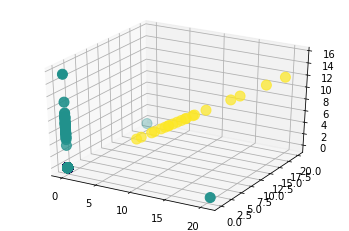

In [169]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics


# #############################################################################
# Generate sample data

X = feature_df
#labels_true = target

#X = feature_df.drop('race',axis=1)
labels_true = feature_df['race']

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 7], X[:, 13] ,X[:, 16], c=y_kmeans, s=100, cmap='viridis')
plt.show()

# #############################################################################
#plt.scatter(X[:, 7], X[:, 16], c=y_kmeans, s=100, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='green', s=50, alpha=0.5);